In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('/project/ssverma_shared/projects/Endometriosis/Endo_Subtyping_Heterogeneity/Cluster_Training/')

In [2]:
from sklearn.cluster import (SpectralClustering, DBSCAN, AgglomerativeClustering, KMeans)

In [3]:
endo_features = pd.read_csv('Data/non_genotyped_PMBB_data_for_no_snps_clustering.csv', index_col='IID')
endo_features

,abdominal_pelvic_pain,abnormal_cholesterol,asthma,dysmenorrhea,dysuria,fibromyalgia,high_risk_pregnancy_supervision,hypertension,ibs,infertility,irregular_menstruation,leiomyoma_of_uterus,lower_abdominal_pain,migraine,pain_with_sex,pcos,shortness_of_breath
IID,,,,,,,,,,,,,,,,,
PMBB1001462384555,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
PMBB1002857391938,1,0,1,1,0,0,0,1,0,0,1,0,1,1,1,0,0
PMBB1003210639911,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
PMBB1003222496744,1,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0
PMBB1003626451826,1,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PMBB9993259322112,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
PMBB9994756680249,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0
PMBB9995182887713,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [6]:
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

def discrete_distortion_score(data, labels):
    centroids = data.groupby(labels).mean().round()

    individual_distortion = pd.Series(dtype=float,index=data.index)

    for group, subDF in data.groupby(labels):
        diff = subDF - centroids.loc[group]
        diff_sq = diff ** 2
        sum_diff_sq = diff_sq.sum(axis=1)
        individual_distortion.loc[subDF.index] = sum_diff_sq

    return individual_distortion.sum()

def distortion_score(data, labels):
    centroids = data.groupby(labels).mean()

    individual_distortion = pd.Series(dtype=float,index=data.index)

    for group, subDF in data.groupby(labels):
        diff = subDF - centroids.loc[group]
        diff_sq = diff ** 2
        sum_diff_sq = diff_sq.sum(axis=1)
        individual_distortion.loc[subDF.index] = sum_diff_sq

    return individual_distortion.sum()

k_list = list(range(2,21))

dfs = []

for k in k_list:
    print(f'K: {k}')
    model_dict = {'Hierarchical': AgglomerativeClustering(n_clusters=k, affinity='manhattan', linkage='complete'),
                  'Spectral': SpectralClustering(n_clusters=k,random_state=314159, assign_labels='cluster_qr'),
                  'K-Means': KMeans(n_clusters=k, random_state=314159),
                  'DBSCAN': DBSCAN(metric='manhattan')
                  }

    sil_score_list = pd.Series(dtype=float, index=model_dict.keys(), name='Manhattan')
    sil_score_list2 = pd.Series(dtype=float, index=model_dict.keys(), name='Euclidean')
    sil_score_list3 = pd.Series(dtype=float, index=model_dict.keys(), name='Cosine')
    distortion_score_list = pd.Series(dtype=float, index=model_dict.keys(), name='Distortion (SSE)')
    distortion_score_list2 = pd.Series(dtype=float, index=model_dict.keys(), name='Discrete Distortion (SSE)')
    proportion_diff_list = pd.Series(dtype=float, index=model_dict.keys(), name='Diff Between Max and Min Clusters')

    for model_name, model in model_dict.items():
        print(f'\t{model_name}')
        clusters = pd.Series(model.fit_predict(endo_features), index=endo_features.index)
        sil_score = silhouette_score(endo_features,clusters,metric='manhattan')
        sil_score_list.loc[model_name] = sil_score
        sil_score = silhouette_score(endo_features,clusters,metric='euclidean')
        sil_score_list2.loc[model_name] = sil_score
        sil_score = silhouette_score(endo_features,clusters,metric='cosine')
        sil_score_list3.loc[model_name] = sil_score
        sil_score = silhouette_score(endo_features,clusters,metric='l1')
        dist_score = distortion_score(endo_features, clusters)
        if model_name == 'DBSCAN':
            print(len(clusters.unique()))
        distortion_score_list.loc[model_name] = dist_score
        dist_score = discrete_distortion_score(endo_features, clusters)
        distortion_score_list2.loc[model_name] = dist_score
        cluster_counts = clusters.value_counts() / clusters.count()
        proportion_diff_list.loc[model_name] = cluster_counts.max() - cluster_counts.min()

    output_df = pd.concat([sil_score_list,
                           sil_score_list2,
                           sil_score_list3,
                           distortion_score_list,
                           distortion_score_list2,
                           proportion_diff_list], axis=1)

    output_df.index.name = 'Model'
    output_df['K'] = k
    dfs.append(output_df)

k_tests = pd.concat(dfs)
k_tests

	K-Means
	DBSCAN
131
K: 3
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 4
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 5
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 6
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 7
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 8
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 9
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 10
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 11
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 12
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 13
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 14
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 15
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 16
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 17
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 18
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 19
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 20
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131


,Manhattan,Euclidean,Cosine,Distortion (SSE),Discrete Distortion (SSE),Diff Between Max and Min Clusters,K
Model,,,,,,,
Hierarchical,0.242815,0.142911,-0.062907,9922.813559,13847.0,0.764100,2
Spectral,0.205670,0.129027,0.099625,9128.575018,12768.0,0.023541,2
K-Means,0.198683,0.124966,0.207877,9034.980751,12465.0,0.163806,2
DBSCAN,0.143900,0.263956,0.098233,6544.695567,9598.0,0.502207,2
Hierarchical,0.111080,0.067729,-0.057008,9533.083566,13148.0,0.558607,3
...,...,...,...,...,...,...,...
DBSCAN,0.143900,0.263956,0.098233,6544.695567,9598.0,0.502207,19
Hierarchical,0.013091,0.036623,-0.078690,7419.246957,10027.0,0.190044,20
Spectral,0.046259,0.071187,0.009492,6847.662051,9329.0,0.102746,20


K: 2
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 3
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 4
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 5
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 6
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 7
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 8
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 9
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 10
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 11
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 12
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 13
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 14
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 15
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 16
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 17
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 18
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 19
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131
K: 20
	Hierarchical
	Spectral
	K-Means
	DBSCAN
131


,Manhattan,Euclidean,Cosine,Distortion (SSE),Discrete Distortion (SSE),Diff Between Max and Min Clusters,K
Model,,,,,,,
Hierarchical,0.242815,0.142911,-0.062907,9922.813559,13847.0,0.764100,2
Spectral,0.205670,0.129027,0.099625,9128.575018,12768.0,0.023541,2
K-Means,0.198683,0.124966,0.207877,9034.980751,12465.0,0.163806,2
DBSCAN,0.143900,0.263956,0.098233,6544.695567,9598.0,0.502207,2
Hierarchical,0.111080,0.067729,-0.057008,9533.083566,13148.0,0.558607,3
...,...,...,...,...,...,...,...
DBSCAN,0.143900,0.263956,0.098233,6544.695567,9598.0,0.502207,19
Hierarchical,0.013091,0.036623,-0.078690,7419.246957,10027.0,0.190044,20
Spectral,0.046259,0.071187,0.009492,6847.662051,9329.0,0.102746,20


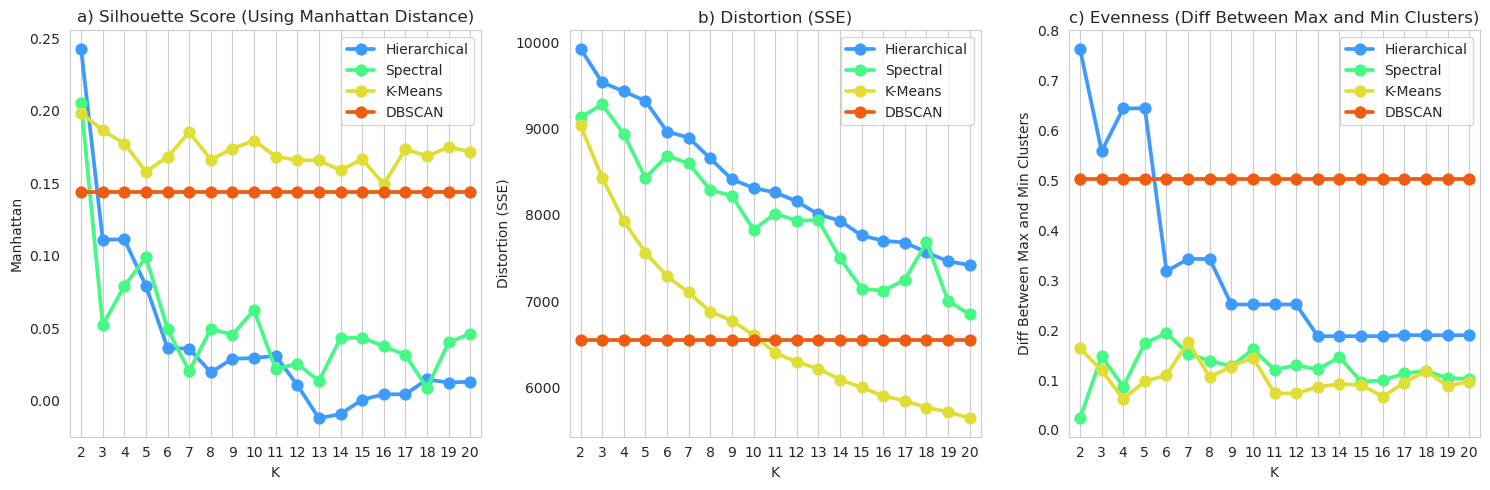

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 5)
metric_axis_pairs = {'Manhattan': axes[0],
                     'Distortion (SSE)': axes[1],
                     'Diff Between Max and Min Clusters': axes[2]}

metric_title_pairs = {'Manhattan': 'Silhouette Score (Using Manhattan Distance)',
                     'Distortion (SSE)': 'Distortion (SSE)',
                     'Diff Between Max and Min Clusters': 'Evenness (Diff Between Max and Min Clusters)'}

i = 0
letters = {0: 'a) ',
           1: 'b) ',
           2: 'c) '}

for metric, ax in metric_axis_pairs.items():
    sns.pointplot(data=k_tests.reset_index(), x='K', y=metric, hue='Model', ax=ax, palette='turbo')
    ax.set_title(f'{letters[i]}{metric_title_pairs[metric]}')
    ax.legend(loc='upper right')
    ax.grid()
    i += 1

# plt.suptitle('Clustering Methods Directly on Features - K Tests')
plt.tight_layout()
plt.savefig('../Manuscript_Plots/figure_1_cluster_method_test_k.png', bbox_inches='tight')
plt.show()